# COGS 108 - Final Project - How Proximity to the Ocean Affects Park Reviews

# Overview

In this project, I looked at the relationship between San Diego's Public parks' distance to the coast and their Yelp rating to see a potential correlation. The dataset used is from Yelp, which stores information on parks' location and their overall rating. I used this information to construct a 'distance from ocean' metric and used it to test the correlation between the rating and this metric, using least squares linear regression. The data showed a very strong lack of correlation between these two variables, resulting in the conclusion that distance from the ocean and the general public's opinion of the park are uncorrelated, contrary to my hypothesis.

# Name & GitHub ID

- Name: Andrew Chang
- GitHub Username: Ajisoo

# Research Question

Does the location of Public Parks in San Diego near proximity to the Ocean have a positive effect the general public's opinion of the park?

## Background and Prior Work

While different people can have very different opinions on individual public parks, the general opinion of the park can be affected by many different aspects, such as quality and frequency of maintenance, types of attractions, popularity, availability, and general size. While general atmosphere likely plays a role, there is a possibility that proximity to the Ocean has an affect on the general public's opinion on the park.

While there is much work on the research of successful public parks, and the situations around them, I have found nothing regarding park reviews and promixity to the coast. However, there are many articles that indirectly state that proximity to the coast can help make a park successful, listed below.

References (include links):
- 1) https://www.miracle-recreation.com/blog/guide-to-designing-park/#section1
- 2) https://generalplan.sfplanning.org/Recreation_OpenSpace_Element_ADOPTED.pdf

# Hypothesis


I believe that public parks in San Diego are, in general, rated higher the closer they are to the coast. This is because I believe public parks that are beaches are more popular, and that those closer to the ocean have a nicer atmosphere due to either a view of the ocean or to the difference in air.

# Dataset(s)

- Dataset Name: yelp_SD_parks.csv
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_parks.csv
- Number of observations: 833

This dataset lists all public parks San Diego, their address, location, yelp review overall status, and some other identification. I am using the rating to track how the general public views this park, along with longitude/latitude for location information, which will be used to calculate distance to shore.

# Setup

In [1]:
# Imports 
%matplotlib inline

import pandas as pd
import matplotlib
import math
import patsy
import statsmodels.api as sm

from IPython.display import Image

df = pd.read_csv('https://raw.githubusercontent.com/COGS108/individual_fa20/master/data/yelp_SD_parks.csv')

# Data Cleaning

First, we must organize our data frame with useful information only. For this project, this is only the review information (rating, review_count) and location (longitude and latitude), keeping name as identifiers.

In [2]:
df = df.set_index('name').drop(['address', 'phone', 'id', 'url', 'is_closed'], axis=1)
df = df.dropna() # Drop empty rows. One Park doesn't have location information, and so is dropped.
df.head()

,rating,review_count,longitude,latitude
name,,,,
Balboa Park,5.0,2105,-117.153150,32.734502
Civita Park,4.5,46,-117.147278,32.778315
Waterfront Park,4.5,242,-117.172479,32.721952
Trolley Barn Park,4.5,102,-117.143789,32.762463
Bay View Park,5.0,42,-117.178967,32.701785


Next, we need to turn longitude and latitude into some form of distance to ocean metric. There are a couple ways of doing this, but I was thinking of defining an approximate contour of the land to the ocean using latitude/longitude line segments, and calculating the distance from the longitude/latitude of each park to the contour.

There are a couple limitations of this method. The first of which, is that this is obviously an approximation. An increase in the number of line segments means a better approximation, but a balance must be struck between speed and precision. Second, is the curvature of the Earth. While I am treating a map as a 2D plane, the surface is really a surface of a sphere (ish), and so distance is actually calculated differently. However, because I am only looking at a small area, I believe this should account for only a very small portion of the error.

In [3]:
lat_long = [
    (33.424, -117.625),
    (33.386, -117.596),
    (33.208, -117.400),
    (33.124, -117.328),
    (33.036, -117.295),
    (33.010, -117.280),
    (32.880, -117.252),
    (32.853, -117.261),
    (32.849, -117.267),
    (32.851, -117.274),
    (32.847, -117.279),
    (32.840, -117.282),
    (32.833, -117.282),
    (32.822, -117.281),
    (32.807, -117.267),
    (32.808, -117.265),
    (32.800, -117.259),
    (32.793, -117.256),
    (32.782, -117.254),
    (32.759, -117.254),
    (32.756, -117.253),
    (32.747, -117.254),
    (32.747, -117.255),
    (32.733, -117.257),
    (32.711, -117.256),
    (32.665, -117.244),
    (32.668, -117.237),
    (32.705, -117.237),
    (32.724, -117.214),
    (32.723, -117.174),
    (32.710, -117.173),
    (32.679, -117.125),
    (32.647, -117.120),
    (32.620, -117.103),
    (32.594, -117.100),
    (32.592, -117.120),
    (32.619, -117.130),
    (32.671, -117.160),
    (32.678, -117.154),
    (32.698, -117.166),
    (32.706, -117.191),
    (32.688, -117.198),
    (32.679, -117.179),
    (32.666, -117.163),
    (32.648, -117.150),
    (32.624, -117.140),
    (32.599, -117.134),
    (32.565, -117.133),
    (32.535, -117.124)
]

lat = [x[0] for x in lat_long]
long = [x[1] for x in lat_long]

![title](all.png)

![title](lower.png)

The images above show the contour points. There are places with farther distance between points that would create an inaccurate contour. This is because there are not any parks that would be closest to the new area.

Now we can use this contour to determine closest distance.

In [4]:
def dot(x, y):
    return x[0]*y[0] + x[1]*y[1]
def dist(x):
    return math.sqrt(x[0]*x[0] + x[1]*x[1])

def get_dist(lat, lng, dbg):
    min_0 = 10000 # Some high number to be overwritten
    index = 0
    for i in range(len(lat_long)-1):
        lat_0 = lat_long[i][0]
        lng_0 = lat_long[i][1]
        lat_1 = lat_long[i+1][0]
        lng_1 = lat_long[i+1][1]
        
        z = (lat - lat_0, lng - lng_0) # Offset values. z is lat/long, z_0 is the endpoint of line
        z_0 = (lat_1 - lat_0, lng_1 - lng_0)
        
        z_parallel = dot(z, z_0)/dot(z_0, z_0) # Find projection
        if z_parallel < 0: # make sure closest point is within the line segment
            z_parallel = 0
        if z_parallel > 1:
            z_parallel = 1
        z_new = (z[0] - z_0[0]*z_parallel, z[1] - z_0[1]*z_parallel) # Find remaining after z - proj_(z_0) z
        z_dist = dist(z_new)
        if z_dist < min_0:
            min_0 = z_dist
            index = i
    if dbg:
        print(index)
        print(lat_long[index])
        print(lat_long[index+1])
    return min_0
        

In [5]:
df['dist'] = df.apply(lambda row : get_dist(row['latitude'], row['longitude'], False), axis=1)

In [6]:
print(df['dist'].tolist())
print(df.head())

[0.023811840592071212, 0.06143138049075876, 0.0014356434143859348, 0.04969968995026098, 0.0003471014562018434, 0.11090710237017613, 0.03317177044095045, 0.022202298989292372, 0.07305840474724609, 0.09116381460875873, 0.09629617235851698, 0.04468162896370558, 0.03663768456354485, 0.0012544074298338219, 0.02671620249082115, 0.08652844217943834, 0.11117402830877267, 0.0009871180000072357, 0.15520350049035056, 0.13891002003094902, 0.10155819094982048, 0.1493014933638549, 0.007762595160010395, 0.07122822495621346, 0.04421430198477578, 0.05292283044282757, 0.038202960369579916, 0.1568626587478356, 0.0008290624869733486, 0.06921281257354017, 0.06972774906018, 0.07606668485682239, 0.06566327755315905, 0.15510801539193822, 0.030473753439565036, 0.12295093686025206, 0.15883773144856253, 0.10225966877026167, 0.00021285248361608856, 0.11920249982436125, 0.1784172943275465, 0.11662404282849122, 0.1310375402590496, 0.0012921537650230305, 0.02843270676435831, 0.1335733154440132, 0.054625317324506484,

We can view by hand a few of these values. Nothing is negative, which is a good sign. By hand comparing the first few values with their distance on google maps, the distance function looks correct!

With this done, we can start analysis!

# Data Analysis & Results

First thing is to graph the correlation between distance and rating. Note that "dist" is defined to be the euclidian distance using the units of longitude/latitude, and is not a standard unit measurement of distance such as miles or kilometers.

Text(0, 0.5, 'Yelp Rating')

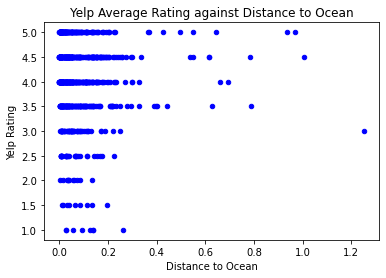

In [7]:
ax = df.plot.scatter(x='dist', y='rating', c='blue', title="Yelp Average Rating against Distance to Ocean")
ax.set_xlabel("Distance to Ocean")
ax.set_ylabel("Yelp Rating")

![title](first.png)

Hard to tell if there is a pattern here, because so many of the data points are grouped together, so it simply looks like a stream of color. Let's try plotting a log scale of the distance instead of just the distance to try and spread out the data.

Text(0, 0.5, 'Yelp Rating')

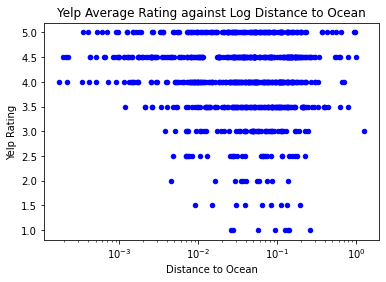

In [8]:
ax = df.plot.scatter(x='dist', y='rating', c='blue', title="Yelp Average Rating against Log Distance to Ocean", logx=True)
ax.set_xlabel("Distance to Ocean")
ax.set_ylabel("Yelp Rating")

![title](first_log.png)

From this we can start to see a small pattern. Although there are not many of the lower ratings, the majority of them happen farther away from the ocean. However, we need to dig deeper to see if there is a true correlation.

Let's try a linear fit!

In [9]:
outcome, predictors = patsy.dmatrices('rating ~ dist', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.001679
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.967
Time:                        00:49:36   Log-Likelihood:                -991.14
No. Observations:                 832   AIC:                             1986.
Df Residuals:                     830   BIC:                             1996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0389      0.033    121.318      0.000       3.974       4.104
dist           0.0095      0.231      0.041      0.967      -0.445       0.464
==============================================================================
Omnibus:                      166.064   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.408
Skew:                          -1.178   Prob(JB):                     1.07e-67
Kurtosis:                       4.830   Cond. No.                         8.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

![title](results.png)

This is a lot of information, not all of which is useful for us, but we can see the F statistic at the top, as well as its probability. This test is testing for correlation, which has the null hypothesis of all independent variables being uncorrelated with the dependent variable. This high probablity score means that we cannot reject the null hypothesis, and that our data shows almost no correlation.

We can also see the analysis of the "dist" coefficient, which is very close to 0. Because we only have one independent variable, this test's P value (P>|t|) has the same value as the F statistic above, as both test H0 as slope=0 against H1 as slope =/= 0

# Ethics & Privacy

There are many possible sources of bias from the data and the data transformation and analysis done. All the data comes from a single dataset, an aggregate from Yelp. First, assuming that Yelp accurately reports the average reviews, there are three different sources of data, the reviews, the location of the park as specified by Yelp, and the existance of the park itself on Yelp. 

First, the existance of the park itself might have a bias towards parks that the general public enjoys more. If a park fails at many aspects of being a park, Yelp may not consider it a park. Also, lesser known parks might not make it onto the list, which has a bias towards the more populated areas/parks, which is likely closer towards the coast.

Second, a park is an area, but Yelp uses a single point to define its location. It is unclear what spot Yelp chooses for each park, but if a specific method is used, this could create bias on the distance to ocean attribute of each park.

Third, the reviews. Reviews themselves are prone to selection bias, with users reviewing more often when having a strong experience at the park, either positive or negative. This will not necessarily represent the general public's view of the park. Also, Yelp only shows review averages to a single decimal point on a 5 point scale, and so the value Yelp shows might not distinguish between two closely-rated, but different, parks.

The analysis and data transformation also has some potential bias. The main one would be the selection of the land/ocean contour of the area. Tradeoffs were made between speed/efficency and precision, as so the contour is not perfectly accurate. Areas with more irregular, jagged coastlines are less precise, which gives rise to inaccuracies in the calculation of "Distance to Ocean", more likely in more populated areas.

There may be concerns over what sensitive data this analysis shows, as well as how this data could be used for other, potentially nefarious purposes.

However, the dataset used only has publically accessable information on Yelp, regarding public reviews of public parks. Unless some parks become private or phone numbers/locations become update with new people/purposes and Yelp becomes updated, in which there will be phone numbers/addresses of potentially private areas, there is no potentially sensitive information.

This analysis uses publically accessable information and does no advanced or unique techniques, besides a contour for the coast of San Diego, so there is little risk over unintended data use.

# Conclusion & Discussion

As shown in the linear regression in the data analysis, our data strongly shows no correlation between distance to ocean and yelp rating. We can use this analysis to answer our research question and state that proximity to the ocean does not have either a positive effect or negative effect on the rating of a public park in San Diego.

I believe this project could be improved in three main ways, by a more precise contour, a different measure of distance and a different method of looking at the general public's opinion.

A more precise contour would require much more time to both generate manually and for the data manipulation, but would improve the accuracy of the distance metric and allow for a more precise log scale of distance. Likely, being 1 mile away from the coast and 5 miles is not a large difference, and so a more precise log scale will make a larger difference.

This is also why a different measure of distance could be beneficial. At some point the effects of proximity to the ocean fall off, and probably not at a log or linear rate. Experimenting with different functions of distance could lead to better results.

Similarly, a rating up to 5 with only 51 unique values (0.0 to 5.0) able to be shown isn't the best way to show public opinion. While I am interested in the overall opinion of a park, and so a singular numeric value makes sense, an option with less discrete options might be preferable.

Overall, I think this project was a success. Although the initial hypothesis appears to be incorrect based on the data, the result was unambiguous and clear, and the result makes sense.